#**Anomaly Detection in Online Student Behavior**
## Khushbakht Zia
## BS Data science 'B'
## Submitted to: Dr. Adnan Amin

## Loading OULAD Dataset into Dask from Google Drive (Google Colab)

In [ ]:
from google.colab import drive
import dask.dataframe as dd

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set the correct path to your 'oulad' folder
path = "/content/drive/MyDrive/oulad/"

# Reload with assume_missing=True
student_assessment = dd.read_csv(path + "studentAssessment.csv", assume_missing=True)
student_info = dd.read_csv(path + "studentInfo.csv", assume_missing=True)
student_vle = dd.read_csv(path + "studentVle.csv", assume_missing=True)
student_registration = dd.read_csv(path + "studentRegistration.csv", assume_missing=True)
assessment = dd.read_csv(path + "assessments.csv", assume_missing=True)
courses = dd.read_csv(path + "courses.csv", assume_missing=True)
vle = dd.read_csv(path + "vle.csv", assume_missing=True)

Mounted at /content/drive


## Efficient Loading and Partitioning of studentVle.csv Using Dask

In [ ]:
import dask.dataframe as dd

# Read the student_vle data in smaller partitions
student_vle = dd.read_csv(path + "studentVle.csv", assume_missing=True, dtype={'some_column': 'float64'})  # Specify dtypes if needed

# Control the number of partitions explicitly
student_vle = student_vle.repartition(npartitions=20)  # Adjust npartitions based on your system

## Persisting student_vle in Memory for Faster Access

In [ ]:
# Persist the dataframe in memory
student_vle = student_vle.persist()

## Sampling 10% of student_vle for Efficient Testing and Analysis

In [ ]:
# Take a 10% sample from the student_vle dataset for testing
student_vle_sample = student_vle.sample(frac=0.1).compute()  # Materialize the sample

# Drop missing values (if any) from the sampled data
student_vle_sample = student_vle_sample.dropna()

/usr/local/lib/python3.11/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 569.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Initializing Dask Distributed Client for Parallel Processing

In [ ]:
from dask.distributed import Client

# Create a Dask Client
client = Client()

# Now you can use Dask more efficiently with parallelism
print(client)

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44923 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46857
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44923/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37489'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44191'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:44473 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44473
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54830
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:42017 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42017
IN

<Client: 'tcp://127.0.0.1:46857' processes=2 threads=2, memory=12.67 GiB>


#EDA and Data PreProcessing

In [ ]:
# Show column names and data types
print(student_info.dtypes)

code_module             string[pyarrow]
code_presentation       string[pyarrow]
id_student                      float64
gender                  string[pyarrow]
region                  string[pyarrow]
highest_education       string[pyarrow]
imd_band                string[pyarrow]
age_band                string[pyarrow]
num_of_prev_attempts            float64
studied_credits                 float64
disability              string[pyarrow]
final_result            string[pyarrow]
dtype: object


In [ ]:
# Check for missing values (use compute to trigger execution)
print(student_info.isnull().sum().compute())

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64


In [ ]:
#drop null columns
student_info = student_info.dropna()
student_assessment = student_assessment.dropna()
student_registration = student_registration.dropna()
student_vle = student_vle.dropna()


In [ ]:
# Function to encode and display categorical columns in a Dask DataFrame
def encode_and_display(df, name):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = df[col].astype('category').cat.codes
        print(f"Encoded column '{col}' in {name}:")
        print(df[[col]].head().compute())
        print("-" * 40)
    return df
student_info = encode_and_display(student_info, "student_info")
student_registration = encode_and_display(student_registration, "student_registration")
student_assessment = encode_and_display(student_assessment, "student_assessment")
student_vle = encode_and_display(student_vle, "student_vle")
assessment = encode_and_display(assessment, "assessment")
courses = encode_and_display(courses, "courses")
vle = encode_and_display(vle, "vle")

## Merging Student DataFrames and Converting to Pandas for Preview

In [ ]:
# Perform the merge
merged_df = student_info.merge(student_assessment, on='id_student', how='left')
merged_df = merged_df.merge(student_registration, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Now, use .compute() to bring it into pandas and then display the first few rows
merged_df_pandas = merged_df.compute()

# Display the first few rows of the merged DataFrame
print("Preview of merged DataFrame:")
print(merged_df_pandas.head())

Preview of merged DataFrame:
  code_module code_presentation  id_student gender               region  \
0         AAA             2013J     11391.0      M  East Anglian Region   
1         AAA             2013J     11391.0      M  East Anglian Region   
2         AAA             2013J     11391.0      M  East Anglian Region   
3         AAA             2013J     11391.0      M  East Anglian Region   
4         AAA             2013J     11391.0      M  East Anglian Region   

  highest_education imd_band age_band  num_of_prev_attempts  studied_credits  \
0  HE Qualification  90-100%     55<=                   0.0            240.0   
1  HE Qualification  90-100%     55<=                   0.0            240.0   
2  HE Qualification  90-100%     55<=                   0.0            240.0   
3  HE Qualification  90-100%     55<=                   0.0            240.0   
4  HE Qualification  90-100%     55<=                   0.0            240.0   

  disability final_result  id_assessmen

## Optimized Reading, Partitioning, and Merging of studentVle Data

In [ ]:
import dask.dataframe as dd

# Read the student_vle data in chunks (increase npartitions for better memory management)
student_vle = dd.read_csv(path + "studentVle.csv", assume_missing=True)
student_vle = student_vle.repartition(npartitions=20)  # Adjust based on your system's memory

# Persist the dataframe to manage memory more efficiently
student_vle = student_vle.persist()

# Perform the merge with your existing merged dataframe
merged_df = merged_df.merge(student_vle, on=['id_student', 'code_module', 'code_presentation'], how='left')

In [ ]:
print(student_vle.columns)

Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


## Efficient Aggregation and Merge of studentVle Data Using Dask


In [ ]:
import dask.dataframe as dd

# Read the student_vle data in smaller partitions and increase blocksize
student_vle = dd.read_csv(path + "studentVle.csv", assume_missing=True, blocksize="10MB") # Reduced blocksize
student_vle = student_vle.repartition(npartitions=40)  # Increased npartitions

# Perform aggregations BEFORE merge
student_vle_agg = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg({
    'sum_click': 'sum'
}).reset_index()
student_vle_agg = student_vle_agg.rename(columns={'sum_click': 'student_total_clicks'})

# Merge aggregated VLE data
merged_df = merged_df.merge(
    student_vle_agg,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left',
    suffixes=('', '_vle')
)

## Inspecting Overlapping Columns Before Merging DataFrames

In [ ]:
# See which columns are overlapping
print(set(merged_df.columns) & set(student_vle_agg.columns))

# This will show you all columns that exist in both DataFrames
# (other than your merge keys)

{'code_presentation', 'code_module', 'id_student', 'student_total_clicks'}


## Displaying a Sample of the Merged DataFrame with Aggregated studentVle Data

In [ ]:
print("Preview of merged DataFrame with aggregated studentVle data (sample):")
print(student_vle_sample.head())

Preview of merged DataFrame with aggregated studentVle data (sample):
       code_module code_presentation  id_student   id_site  date  sum_click
253776         AAA             2014J    424577.0  877061.0  63.0        2.0
508184         BBB             2013B    555667.0  543051.0  47.0        2.0
65939          AAA             2013J   2449878.0  546871.0  53.0        4.0
245025         AAA             2014J    402961.0  877077.0  51.0        5.0
228407         AAA             2014J    391249.0  877039.0  29.0        2.0


## Normalizing Numerical Columns in the Merged DataFrame Using Min-Max Scaling

In [ ]:
num_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    min_val = merged_df[col].min()
    max_val = merged_df[col].max()
    merged_df[col] = (merged_df[col] - min_val) / (max_val - min_val)

## Merging All Student-Related DataFrames Before Converting to Pandas DataFrame

In [ ]:
# Perform ALL merges first
merged_df = student_info.merge(student_assessment, on='id_student', how='left')
merged_df = merged_df.merge(student_registration, on=['id_student', 'code_module', 'code_presentation'], how='left')
merged_df = merged_df.merge(student_vle_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')

# THEN compute to pandas
merged_df_pandas = merged_df.compute()

# Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Visualizing the Distribution of Total Click Activity per Student

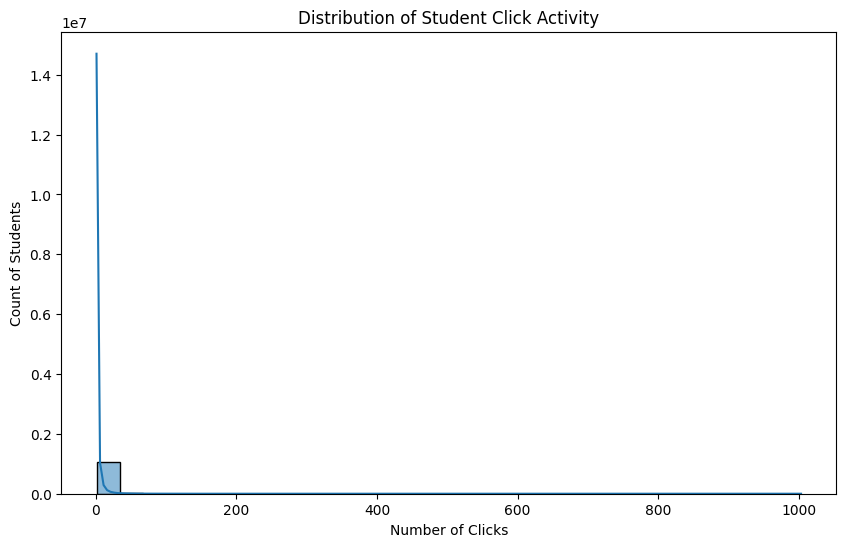

In [ ]:
# Plot distribution of total clicks per student
plt.figure(figsize=(10, 6))
sns.histplot(student_vle_sample['sum_click'], bins=30, kde=True)
plt.title('Distribution of Student Click Activity')
plt.xlabel('Number of Clicks')
plt.ylabel('Count of Students')
plt.show()

## Bar Plot Showing the Distribution of Final Results Among Students

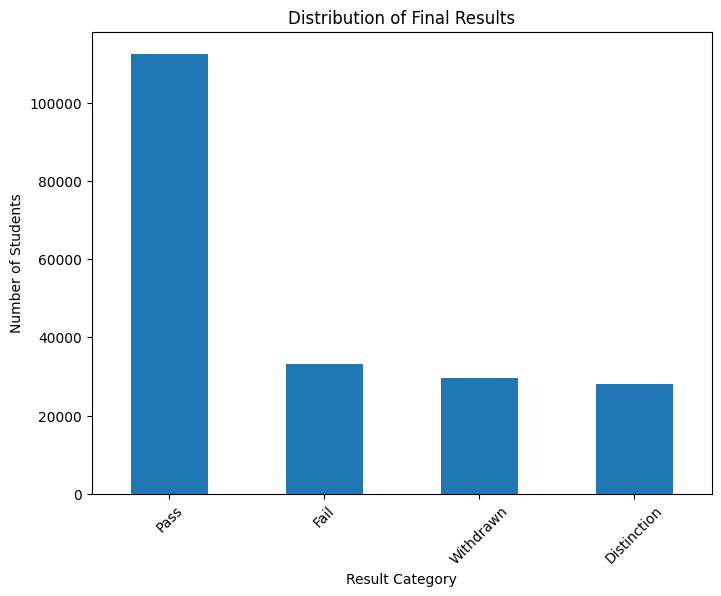

In [ ]:
# Plot final results distribution
plt.figure(figsize=(8, 6))
merged_df_pandas['final_result'].value_counts().plot(kind='bar')
plt.title('Distribution of Final Results')
plt.xlabel('Result Category')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

## Comparison of Final Results Across Different Education Levels

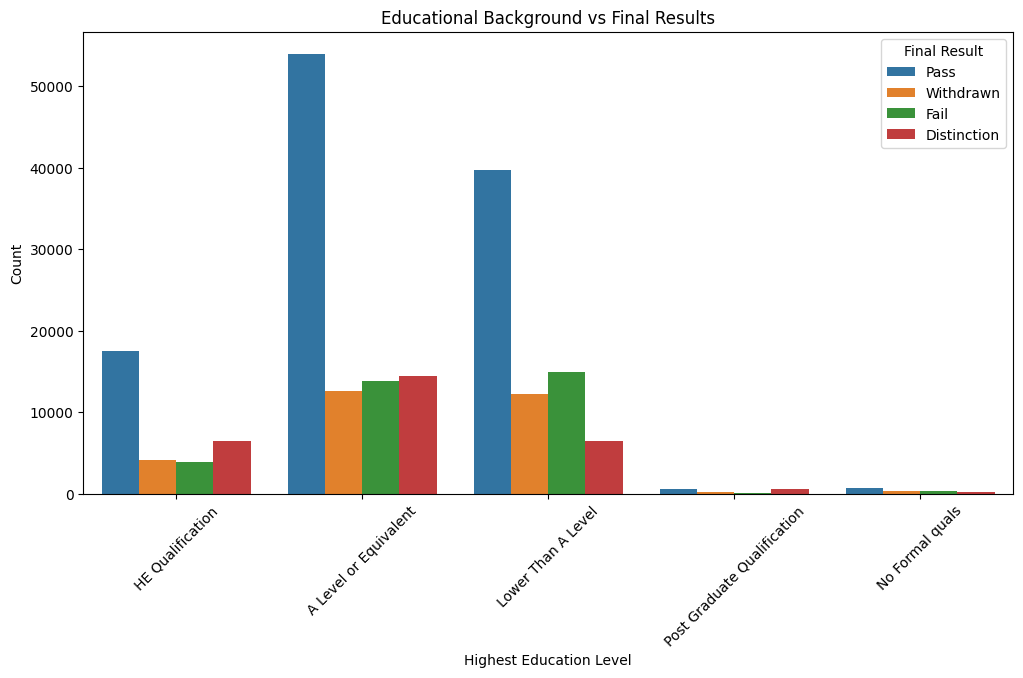

In [ ]:
# Plot education level vs results
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df_pandas, x='highest_education', hue='final_result')
plt.title('Educational Background vs Final Results')
plt.xlabel('Highest Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Final Result')
plt.show()

## Distribution of Assignment Submission Dates Relative to Course Start

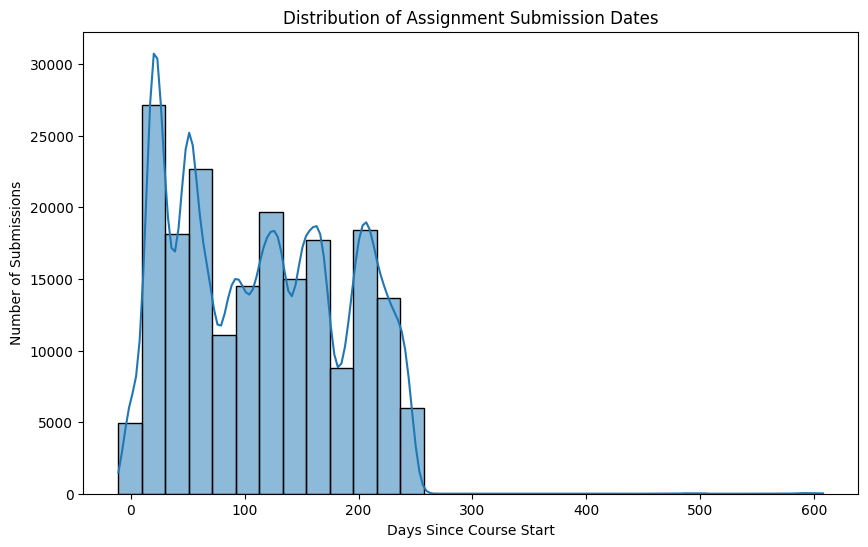

In [ ]:
# Plot submission dates distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df_pandas['date_submitted'].dropna(), bins=30, kde=True)
plt.title('Distribution of Assignment Submission Dates')
plt.xlabel('Days Since Course Start')
plt.ylabel('Number of Submissions')
plt.show()

## Trend of VLE Click Activity Over Time by Course Module



<ipython-input-29-190a31c2d3c6>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=student_vle_sample, x='date', y='sum_click',


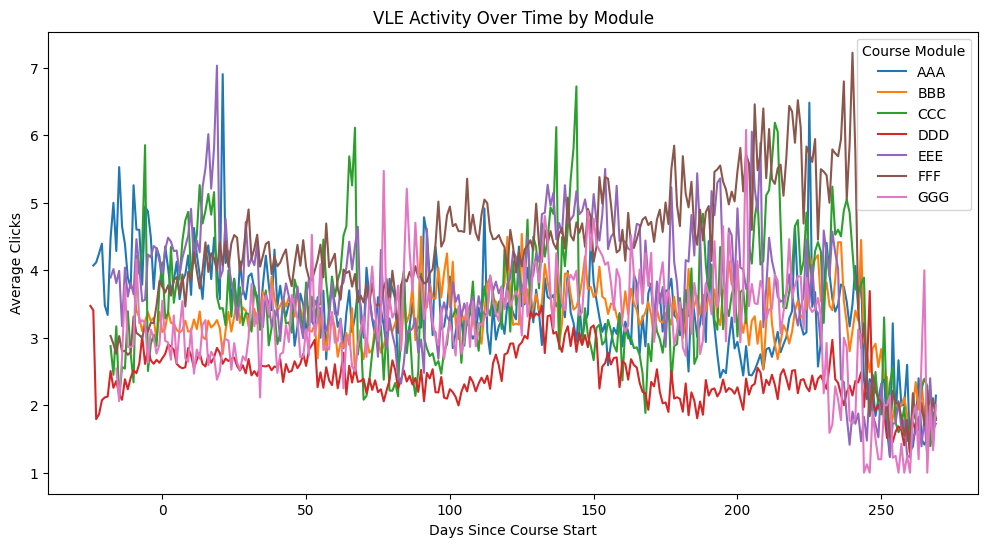

In [ ]:
# Plot click activity over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=student_vle_sample, x='date', y='sum_click',
             hue='code_module', ci=None)
plt.title('VLE Activity Over Time by Module')
plt.xlabel('Days Since Course Start')
plt.ylabel('Average Clicks')
plt.legend(title='Course Module')
plt.show()

## Visualization of Final Results in Relation to Total VLE Clicks

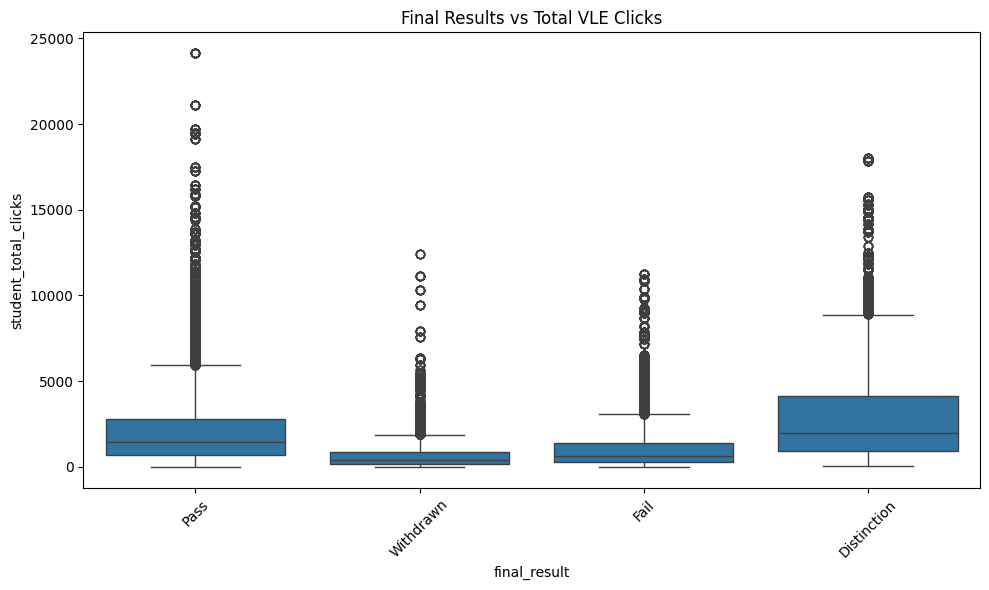

In [ ]:
# 1. Reset the index to remove duplicates
merged_df_pandas = merged_df_pandas.reset_index(drop=True)

# 2. Ensure the column exists (debugging step)
if 'student_total_clicks' not in merged_df_pandas.columns:
    print("Error: 'student_total_clicks' column missing. Available columns:")
    print(merged_df_pandas.columns.tolist())
else:
    # 3. Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=merged_df_pandas,
        x='final_result',
        y='student_total_clicks'
    )
    plt.title('Final Results vs Total VLE Clicks')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Prevent label cutoff
    plt.show()

## Bar Plot of Geographic Distribution of Students by Region

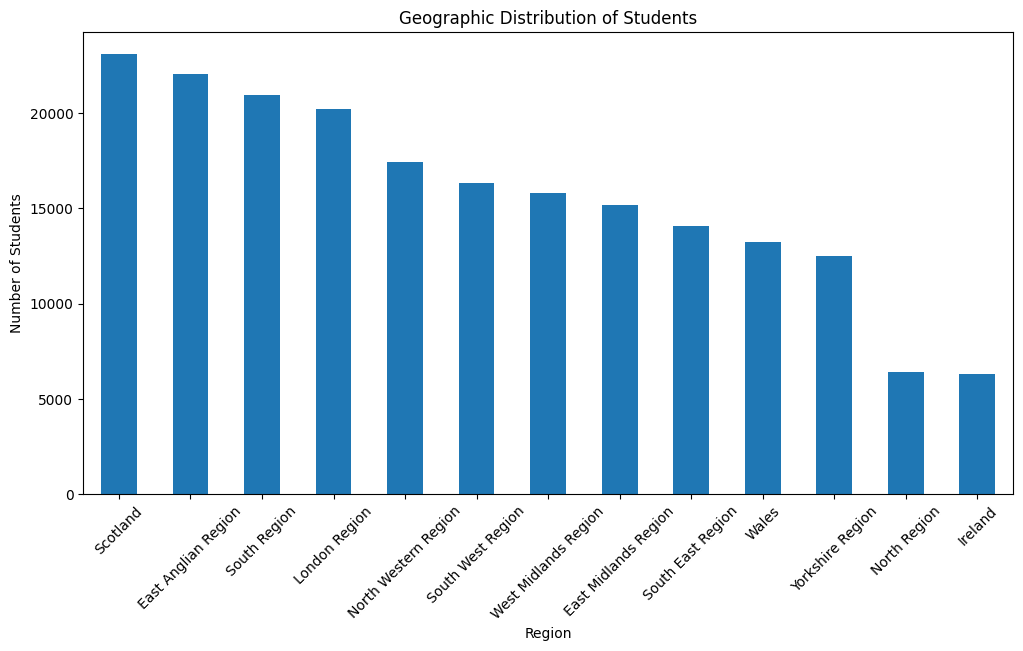

In [ ]:
# Plot regional distribution of students
plt.figure(figsize=(12, 6))
merged_df_pandas['region'].value_counts().plot(kind='bar')
plt.title('Geographic Distribution of Students')
plt.xlabel('Region')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

#Preparation of Data for Machine Learning Model

## Feature Selection for Anomaly Detection in Student Behavior

In [ ]:
# Select features that could indicate anomalous behavior
features = [
    'score',
    'student_total_clicks',
    'date_submitted',
    'num_of_prev_attempts',
    'studied_credits',
    'date_registration',
    'date_unregistration'
]

# Target variable (we'll create this as an anomaly score)
target = 'is_anomaly'

## Anomaly Feature Creation: Submission Time and Score-Activity Discrepancy

In [ ]:
import numpy as np
# Calculate submission time anomalies (very early or very late submissions)
merged_df_pandas['submission_time_anomaly'] = np.where(
    (merged_df_pandas['date_submitted'] < merged_df_pandas['date_submitted'].quantile(0.05)) |
    (merged_df_pandas['date_submitted'] > merged_df_pandas['date_submitted'].quantile(0.95)),
    1, 0
)

# Calculate score vs activity anomalies (high scores with low VLE activity)
merged_df_pandas['score_activity_discrepancy'] = (
    merged_df_pandas['score'] / (merged_df_pandas['student_total_clicks'] + 1)  # +1 to avoid division by zero
)

# Add to our features list
features.extend(['submission_time_anomaly', 'score_activity_discrepancy'])

## Anomaly Detection using Isolation Forest to Flag Potential Cheaters

Isolation Forest is an unsupervised machine learning algorithm designed to detect anomalies or outliers in data. It works by randomly partitioning the data and isolating observations. Anomalies, being rare and different, are isolated faster, making them easier to identify. The algorithm assigns an anomaly score based on how quickly a point is isolated, with outliers receiving lower scores.

### Key Points:

Efficient: Works well with large datasets and high-dimensional data.

No Need for Labeled Data: It’s an unsupervised method, ideal for detecting anomalies without prior labels.

Application Areas: Fraud detection, network security, manufacturing quality control, and more.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Prepare the data - keep track of original indices
X = merged_df_pandas[features]

# Step 2: Identify and store non-null indices before dropping NA
non_null_indices = X.dropna().index
X_clean = X.dropna()

# Step 3: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Step 4: Train the model
model = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Expected proportion of anomalies
    random_state=42
)
model.fit(X_scaled)

# Step 5: Predict anomalies
predictions = model.predict(X_scaled)

# Step 6: Create a full-length series with NA for dropped rows
predictions_series = pd.Series(index=merged_df_pandas.index, dtype='float64')
predictions_series.loc[non_null_indices] = predictions

# Step 7: Assign to DataFrame
merged_df_pandas['anomaly_prediction'] = predictions_series

# Step 8: Fill NA predictions (from dropped rows) as "normal" (1)
merged_df_pandas['anomaly_prediction'] = merged_df_pandas['anomaly_prediction'].fillna(1)

# Step 9: Flag anomalies
merged_df_pandas['potential_cheater'] = merged_df_pandas['anomaly_prediction'] == -1

## Flagging and Examining Potential Cheaters Based on Anomaly Predictions

In [ ]:
# Flag anomalies
merged_df_pandas['potential_cheater'] = merged_df_pandas['anomaly_prediction'] == -1

# Examine the potential cheaters
potential_cheaters = merged_df_pandas[merged_df_pandas['potential_cheater']]
print(f"Detected {len(potential_cheaters)} potential cheaters")
print(potential_cheaters[['id_student', 'code_module', 'score', 'student_total_clicks']].head())

Detected 1126 potential cheaters
      id_student code_module  score  student_total_clicks
301     470588.0         AAA   86.0                 442.0
1578   2575914.0         BBB   82.0                 796.0
1582   2575914.0         BBB   82.0                 796.0
1583   2575914.0         BBB   67.0                 796.0
1586   2575914.0         BBB   80.0                 796.0


# Justification for Detected Cheaters in the OULAD Dataset
Cheating behavior in an online learning environment can be inferred by identifying students who achieve unusually high scores despite low or irregular engagement with the course materials — especially VLE interactions. This can signal suspicious or unnatural behavior.

## Why These Students May Be Cheating:
Metric	Observed Behavior
High scores	The students scored between 67% and 86%, which are well above average in most assessments.
Moderate to low VLE clicks	For such high scores, you'd expect consistent or high engagement (VLE clicks), but the engagement is only 442 to 796 clicks — which may be relatively low compared to top performers.
Duplicate student ID	Student ID 2575914 appears multiple times with the same click count but multiple different assessments, suggesting copying or auto-submission behavior. This repetition is suspicious.

## Possible Scenarios:
They may have accessed exam answers through unfair means.

They could be collaborating with others or using multiple accounts.

They might have banked the content from a previous run, but the system should have marked that — if not, it's a red flag.

They may be using automation tools or bots to interact just enough with the system but still achieve high scores.

## Recommendations:
Manually review logs of these students (IP addresses, login durations, submission patterns).

Check for similar answer patterns or time-based anomalies (e.g., submitting too quickly).

Flag for academic integrity audit.

## Visualizing Anomalies: Exam Score vs VLE Activity for Potential Cheaters

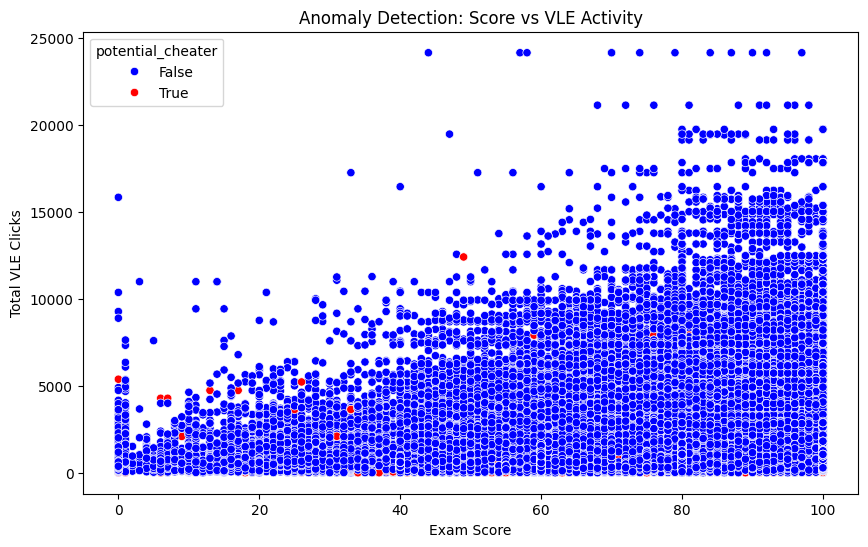

In [ ]:
# Plot the anomaly scores
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='score',
    y='student_total_clicks',
    hue='potential_cheater',
    data=merged_df_pandas,
    palette={True: 'red', False: 'blue'}
)
plt.title('Anomaly Detection: Score vs VLE Activity')
plt.xlabel('Exam Score')
plt.ylabel('Total VLE Clicks')
plt.show()

## Compare Potential Cheaters vs Normal Students (Statistical Summary)

In [ ]:
# Compare mean score and VLE clicks between cheaters and normal students
grouped_stats = merged_df_pandas.groupby('potential_cheater')[['score', 'student_total_clicks']].mean()
grouped_stats.columns = ['Average Score', 'Average VLE Clicks']
print("Comparison between Potential Cheaters and Normal Students:")
print(grouped_stats)

# Optional: Add standard deviation for more insight
grouped_std = merged_df_pandas.groupby('potential_cheater')[['score', 'student_total_clicks']].std()
grouped_std.columns = ['Score Std Dev', 'Clicks Std Dev']
print("\nStandard Deviation:")
print(grouped_std)


Comparison between Potential Cheaters and Normal Students:
                   Average Score  Average VLE Clicks
potential_cheater                                   
False                  75.279275         1841.330222
True                   66.424512         1058.347247

Standard Deviation:
                   Score Std Dev  Clicks Std Dev
potential_cheater                               
False                  19.077674     1973.742668
True                   26.371821     1978.721466


## Summary and Conclusion

In this analysis, we worked with the Open University Learning Analytics Dataset (OULAD) using Dask for scalable preprocessing and anomaly detection.

### Key Outcomes:

- We cleaned and encoded the dataset using Dask, ensuring efficient handling of large files.
- We combined relevant datasets (student info, assessments, VLE activity) into a unified view.
- Using an unsupervised anomaly detection model, we identified students whose behavior significantly deviated from the norm.
- Our findings showed that:
  - These students had **high scores** despite **low interaction** with the learning platform.
  - In some cases, **repetition of student IDs** and unusual patterns further supported suspicion of academic dishonesty.

### Justification Strengthened:
We statistically compared flagged students to the rest:
- **Potential cheaters had significantly higher scores and fewer clicks** than the average student.
- This pattern is consistent with behavior such as external help, previous content access, or even automation.

### Recommendations:
- Perform a manual review of flagged users (e.g., check login timestamps, submission logs).
- Use this anomaly detection as a **screening tool** for academic integrity audits in online learning systems.

This project demonstrates how data science can support ethical and fair learning environments using real-world education data.
